# 1d-signal data augmentation for regression
https://github.com/fdesmond/seme-ts

This version uses StandardScaler and TransformedTargetRegressor.

In [1]:
# standard modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# ml functions
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# tsmall module
from tsmall import *

In [2]:
np.random.seed(23)

In [3]:
# KNN with GridSearch and cv=3 + applying log transformation to target variable
def run_knn(X_train, Y_train):
    '''run KNN wit CV.

    return: trained model.
    '''
    params_knn = {'n_neighbors':list(np.arange(10, 30, 2))}
    knn = KNeighborsRegressor()
    gs = GridSearchCV(knn, param_grid=params_knn, cv=3, scoring='neg_mean_squared_error')
    tt = TransformedTargetRegressor(regressor=gs, func=np.log1p, inverse_func=np.expm1)
    tt.fit(X_train, Y_train)
    return tt

## The energy dataset 
We consider the [Appliances energy prediction Data Set](https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction). The dataset is ready-to-use, however, we filter the most important features following the related publication [Data driven prediction models of energy use of appliances in a low-energy house](https://www.sciencedirect.com/science/article/pii/S0378778816308970?via%3Dihub): we ignore `lights`, `Visibility`, `rv1` and `rv2`. We end up with 23 features and one target variable `Appliances`.

The main goal is to predict energy appliance of a specific house, by monitoring a few parameters from inside and outside the building, e.g., temperature and humidity in different rooms.

### `data_A` dataframe
The dataframe `data_A` is a filtered version of the original dataset: we select 3000 observations out of 19735, corresponding to a one-month time period from `2016-01-20` to `2016-02-15`. Observe that the `date` column is used as a index: we are not going to exploit the time-series properties of the features, but only the 1d-signal nature (see below in Data Augmentation to build `data_C`)

In [4]:
# load the dataset
energy = pd.read_csv('energy_data.csv', parse_dates=['date'])
energy.set_index('date', inplace=True)

# most important columns, Appliances put in the end
ts_index = ['T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Tdewpoint', 'Appliances']

# consider a part of the whole energy dataset
data_A = energy[ts_index].iloc[2000:5000].copy()    
data_A['Appliances'] = energy['Appliances'].iloc[2000:5000]

# show dataset dimensions
print('energy dataset size: \t {}'.format(energy.shape) + '\n' +\
      'data_A size: \t \t {}'.format(data_A.shape))

energy dataset size: 	 (19735, 28)
data_A size: 	 	 (3000, 24)


#### quick EDA 
A few plots to grasp the dataset structure.


[Text(0.5, 0, 'Appliances'), Text(0.5, 1.0, 'Histogram')]

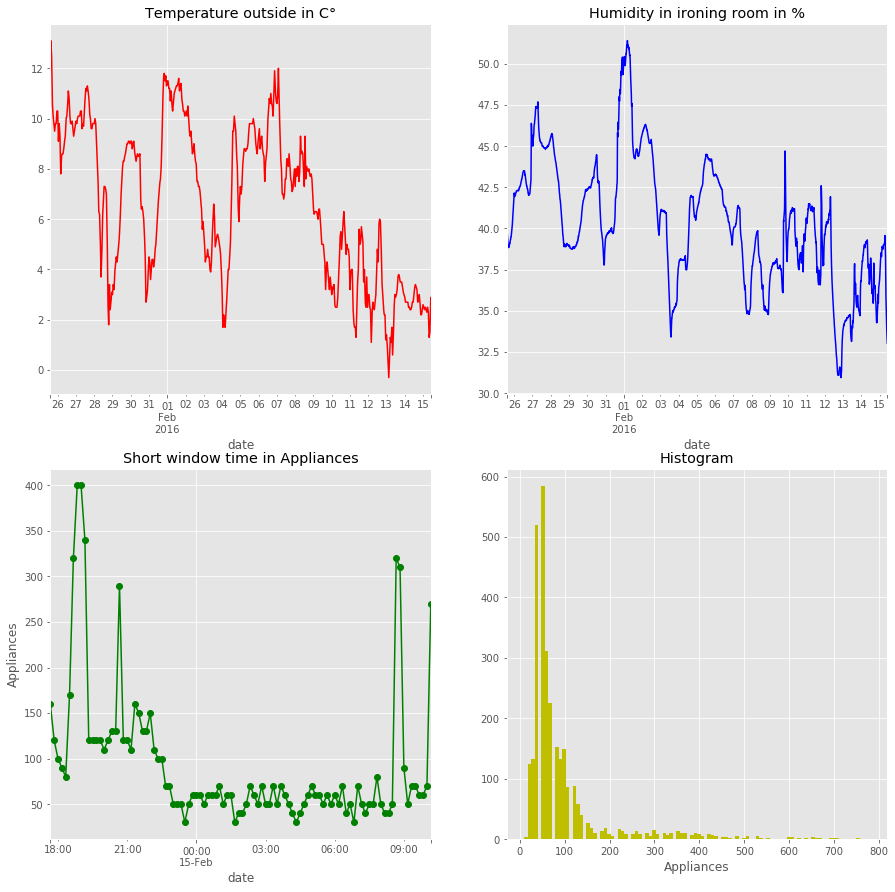

In [5]:
fig, ax = plt.subplots(figsize=[15,15], nrows=2, ncols=2)
data_A.T_out.plot(ax=ax[0,0], title='Temperature outside in C°', color='r')
data_A.RH_7.plot(ax=ax[0,1], title='Humidity in ironing room in %', color='b')
data_A.Appliances.iloc[-100:].plot(marker='o', color='g', title='Short window time in Appliances', ax=ax[1,0]).set(ylabel='Appliances')
data_A.Appliances.hist(bins=100, ax=ax[1,1], color='y').set(title='Histogram', xlabel='Appliances')

### obtaining `data_B` and `data_C` 
We now focus on obtaining `data_B` and `data_C` dataframes.

#### subsampling for `data_B` 
The train set and the test set for `data_B` are obtained through uniform subsampling from `xtrain_A`, `ytrain_A` and `xtest_A`, `ytest_A` respectively.

In [6]:
# train-test-split of data_A
y_A = data_A.Appliances
X_A = data_A.drop(columns='Appliances')
xtrain_A, xtest_A, ytrain_A, ytest_A = train_test_split(X_A, y_A, test_size=0.3)

Observations in data_B:	 300
xtrain_B size: 	 	 210
xtest_B size: 	 	 90


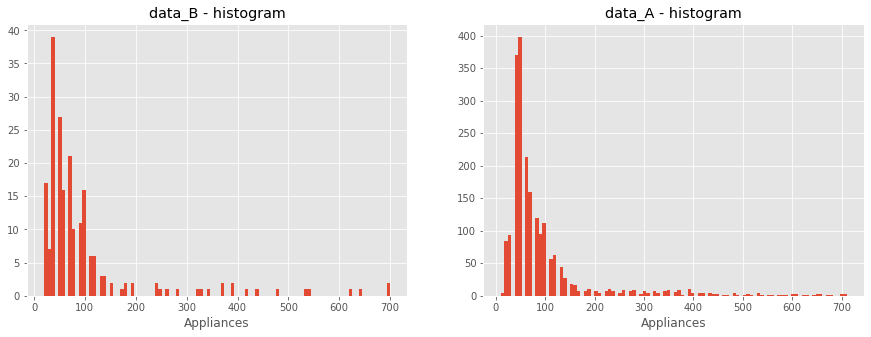

In [7]:
# train-test-split of data_B
p = 0.1 # propotion of data_A in data_B
xtrain_B = xtrain_A.sample(frac = p)
ytrain_B = ytrain_A.loc[xtrain_B.index]

xtest_B = xtest_A.sample(frac = p)
ytest_B = ytest_A.loc[xtest_B.index]

# visually check that the data_B has a similar Appliances histogram
fig, ax = plt.subplots(figsize=[15,5], nrows=1, ncols=2)
ax[0].set(title='data_B - histogram', xlabel='Appliances')
ax[1].set(title='data_A - histogram', xlabel='Appliances')
ytrain_B.hist(bins=100, ax=ax[0])
ytrain_A.hist(bins=100, ax=ax[1])

# show dataset dimensions
print('Observations in data_B:\t {:.0f}'.format(data_A.shape[0]*p) + '\n' +\
      'xtrain_B size: \t \t {}'.format(xtrain_B.shape[0]) + '\n' +\
      'xtest_B size: \t \t {}'.format(xtest_B.shape[0]))

#### data augmentation with `dfaug()` for `data_C` 
Data augmentation is performed by `dfaug()` and `tsaug()` functions in `tsmall.augment`. The output, `data_C`, is a dataframe consisting in the original dataframe, i.e., `data_B`, plus a distorted version of it.

The signal distortion is made by the function `tsaug()` applied to a randomly selected time window of a feature (iterating on time-windows and random features): it consists in applying white noise at the level of the [FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform) or [FWT](https://en.wikipedia.org/wiki/Fast_wavelet_transform), and inverting the signal back using the inverse function, IFFT or IFWT respectively.

This subsection shows a very direct use of `dfaug()`, but not the one that will be used later on. For a multiclass implementation of `dfaug()` see the function `mdfaug()` and the forthcoming code.

In [8]:
# a basic example of data augmentation using the 'wavelet' method with a distortion coefficient of 0.5
train_C = dfaug(pd.concat([xtrain_B, ytrain_B], axis=1), sigma=0.3, method='wavelet', y_dist=True)

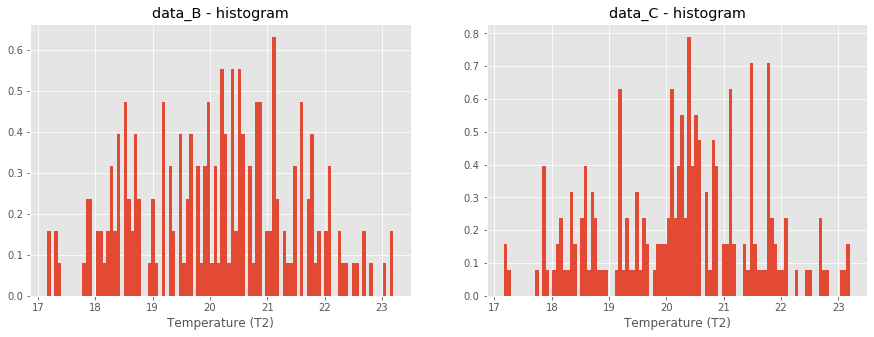

In [9]:
# visually check that the data_B has a similar Appliances histogram
fig, ax = plt.subplots(figsize=[15,5], nrows=1, ncols=2)
ax[0].set(title='data_B - histogram', xlabel='Temperature (T2)')
ax[1].set(title='data_C - histogram', xlabel='Temperature (T2)')

xtrain_B.T2.hist(bins=100, ax=ax[0], density=True)
train_C.T2.hist(bins=100, ax=ax[1], density=True)

##### we should not touch the labels
...or apply a different transformation!

By using `y_dist=True` in `dfaug()`, we can perturb the label variable as well. However this did not improve the performance, observe that the histograms do not coincide always coincide.

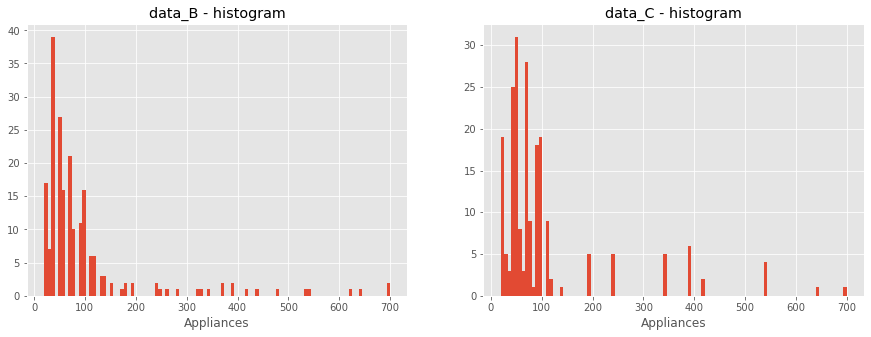

In [10]:
fig, ax = plt.subplots(figsize=[15,5], nrows=1, ncols=2)
ax[0].set(title='data_B - histogram', xlabel='Appliances')
ax[1].set(title='data_C - histogram', xlabel='Appliances')

ytrain_B.hist(bins=100, ax=ax[0])
train_C.Appliances.hist(bins=100, ax=ax[1])

### fitting and metrics
#### `model_A`
We use `run_knn()` defined in the beginning to run a `GridSearchCV(cv=3)` with KNN algorithm. The output model is called `model_A`.

We use two different metrics to asses the performance of the model:
- RMSE : root mean squared error in `rmse_AA`
- R2 : R2 score in `R2_AA`

In [11]:
# scaling
ss_A = StandardScaler()
sxtrain_A = ss_A.fit_transform(xtrain_A)
sxtest_A = ss_A.transform(xtest_A)

# fitting
model_A = run_knn(X_train = sxtrain_A, Y_train = ytrain_A)
ypred_A = model_A.predict(sxtest_A)

# metrics
rmse_AA = mean_squared_error(ytest_A, ypred_A, squared=False)
R2_AA = r2_score(ytest_A, ypred_A)

In [12]:
display('model_A on test_A:    MSE {:.2f}    R2 {:.2f}'.format(rmse_AA,R2_AA))

'model_A on test_A:    MSE 92.56    R2 0.32'

#### `model_B` and `model_C`
In order to asses the performance of the data augmentation procedure, we subsample `data_A` multiple times and, for each sample `data_B`, we apply data augmentation to retrieve a new `data_C` dataframe. For each `data_B` and `data_C`, two models `model_B` and `model_C` are fit as done for `model_A`.

We compare the mean RMSE and R2 score and we plot a histogram of the results.

##### a quick look on the *categorical* augmentation technique
Contrary to the previous case, we perform data augmentation by slincing `xtrain_B` for the observations which have a similar label and apply the `dfaug()` to each slice.

The general algorithm goes as follow:
1. fix the number of different `y`-class by setting `n_bin`
2. compute the `n_bin` quantile intervals for `y` in `y_train_B_bin`
3. for each quantile interval in `y_train_B_bin`:
   - slice `xtrain_B` and select only the observations `xtrain_B_bin_sample` with label in the interval
   - apply `dfaug()` to `xtrain_B_sample`
   - append the augmented dataframe to `xtrain_C`
4. fit KNN on `xtrain_C` to obtain `model_C`

Observe that this latter technique is breaking the local time-structure of the dataset, but it keeps the categorical structure given by the `y` label.

In [13]:
n_bin = 9
n_tries = 50

# initialize list of results
R2_B = np.zeros(shape = (n_tries,2))
R2_C = np.zeros(shape = (n_tries,2))
rmse_B = np.zeros(shape = (n_tries,2))
rmse_C = np.zeros(shape = (n_tries,2))


for k in range(n_tries):  
    # sample data_B
    xtrain_B = xtrain_A.sample(frac = p, random_state=k)
    ytrain_B = ytrain_A.loc[xtrain_B.index]

    xtest_B = xtest_A.sample(frac = p, random_state=k)
    ytest_B = ytest_A.loc[xtest_B.index]

    
    #------------------------------------------
    #  data augmentation strategy 1 for data_C
    #------------------------------------------
    #train_B = pd.concat([xtrain_B, ytrain_B], axis=1)
    #train_C = mdfaug(train_B, n_true = 3, n_f1 = 2, n_f2 = 2, n_w = 2, \
    #                sigma_list_f1 = [0.3, 0.3], ff_list_f1=[0.5, 0.5], \
    #               sigma_list_f2 = [0.5, 0.2], ff_list_f2=[0.6, 0.5], \
    #                sigma_list_w = [0.7, 0.6], ff_list_w=[0.5, 0.7] \
    #               )
    #------------------------------------------


    #------------------------------------------
    #  data augmentation strategy 2 for data_C
    #------------------------------------------
    ytrain_B = ytrain_B + np.random.normal(0, 0.01, size=len(ytrain_B))  # avoid concentration on unique values
    ytrain_B_bin = pd.qcut(ytrain_B, n_bin).value_counts().sort_index()  # retreive quantile intervals
    
    train_C = pd.DataFrame(columns=data_A.columns)   # initialize data_C
    
    # run categorical data augmentation
    for i in range(n_bin):
        row_id = ytrain_B.apply(lambda x: np.round(x,3) in ytrain_B_bin.index.values[i])
        train_B_bin_sample = pd.concat([ xtrain_B.loc[row_id], ytrain_B.loc[row_id] ], axis=1)
        
        # augmentation with combined techniques: fourier1, fourier2 and wavelet
        train_C_bin_sample = mdfaug(train_B_bin_sample, n_true = 3, n_f1 = 2, n_f2 = 2, n_w = 2, \
                        sigma_list_f1 = [0.3, 0.3], ff_list_f1=[0.5, 0.4], \
                        sigma_list_f2 = [0.5, 0.2], ff_list_f2=[0.5, 0.6], \
                        sigma_list_w = [0.7, 0.5], ff_list_w=[0.5, 0.7], \
                        y_dist=False\
                        )
        train_C = train_C.append(train_C_bin_sample) 
        del train_B_bin_sample, train_C_bin_sample
    #------------------------------------------
    
    
    # obtain train set from data_C
    ytrain_C = train_C.Appliances
    xtrain_C = train_C.drop(columns='Appliances')
    
    # scaling
    ss_B = StandardScaler()
    sxtrain_B = ss_B.fit_transform(xtrain_B)
    sxtest_B = ss_B.transform(xtest_B)
    
    ss_C = StandardScaler()
    sxtrain_C = ss_C.fit_transform(xtrain_C)
    
    # model fitting
    model_B = run_knn(X_train = sxtrain_B, Y_train = ytrain_B)
    model_C = run_knn(X_train = sxtrain_C, Y_train = ytrain_C)
    
    # save performances    
    R2_B[k, 0] = r2_score(ytest_B, model_B.predict(sxtest_B))
    rmse_B[k, 0] = mean_squared_error(ytest_B, model_B.predict(sxtest_B), squared=False)
    R2_B[k, 1] = r2_score(ytest_A, model_B.predict(sxtest_A))
    rmse_B[k, 1] = mean_squared_error(ytest_A, model_B.predict(sxtest_A), squared=False)
    R2_C[k, 0] = r2_score(ytest_B, model_C.predict(sxtest_B))
    rmse_C[k, 0] = mean_squared_error(ytest_B, model_C.predict(sxtest_B), squared=False)
    R2_C[k, 1] = r2_score(ytest_A, model_C.predict(sxtest_A))
    rmse_C[k, 1] = mean_squared_error(ytest_A, model_C.predict(sxtest_A), squared=False)

### Results
There is statistical evidence that `model_C` is outperforming `model_B`: not only for different realization of `data_B` and `data_C`, but also by fixing `data_B` and `data_C` and running the two corresponding model on different test sets from `data_A`.

For KNN algorithm, we obtain a fair improvement on the R2 score and -5% on the MSE.

In [14]:
print('-'*100 + '\n' + 'Results' + '\n' + '-'*100)
display('model_A on test_A:    MSE {:.2f}    R2 {:.2f}'.format(rmse_AA,R2_AA))
print('-'*100)
display('model_B on test_B:    MSE {:.2f}    R2 {:.3f} ({} times average)'.format(rmse_B[:,0].mean(), R2_B[:,0].mean(), n_tries),\
        'model_B on test_A:    MSE {:.2f}    R2 {:.3f} ({} times average)'.format(rmse_B[:,1].mean(), R2_B[:,1].mean(), n_tries))
print('-'*100)
display('model_C on test_B:    MSE {:.2f}    R2 {:.3f} ({} times average)'.format(rmse_C[:,0].mean(), R2_C[:,0].mean(), n_tries),\
        'model_C on test_A:    MSE {:.2f}    R2 {:.3f} ({} times average)'.format(rmse_C[:,1].mean(), R2_C[:,1].mean(), n_tries))
print('-'*100 + '\n' + 'Size of train_C = {:.0f}'.format(sxtrain_C.shape[0])\
              + '\n' + 'Size of train_B = {:.0f}'.format(sxtrain_B.shape[0]))

----------------------------------------------------------------------------------------------------
Results
----------------------------------------------------------------------------------------------------


'model_A on test_A:    MSE 92.56    R2 0.32'

----------------------------------------------------------------------------------------------------


'model_B on test_B:    MSE 110.56    R2 0.012 (50 times average)'

'model_B on test_A:    MSE 111.61    R2 0.015 (50 times average)'

----------------------------------------------------------------------------------------------------


'model_C on test_B:    MSE 104.31    R2 0.103 (50 times average)'

'model_C on test_A:    MSE 105.83    R2 0.113 (50 times average)'

----------------------------------------------------------------------------------------------------
Size of train_C = 1740
Size of train_B = 210


#### a few plots
We compare the predicted realizations, but also how the data augmentation changes (in mean and median) the model performance. We do this by plotting the RMSE score for different models but also for a same model but on different subset of `data_A`.

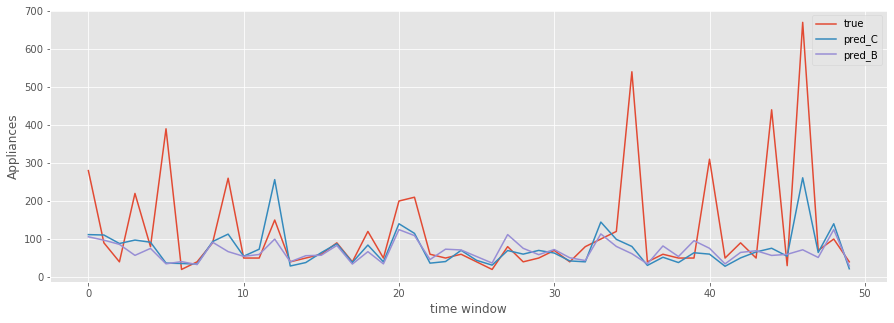

In [15]:
plt.rcParams['figure.figsize'] = [15, 5]
s=300
i=50
plt.plot(range(i), ytest_A[s:s+i], label = "true")
plt.plot(range(i), model_C.predict(sxtest_A[s:s+i]), label = "pred_C")
plt.plot(range(i), model_B.predict(sxtest_A[s:s+i]), label = "pred_B")
#plt.plot(range(i), model_A.predict(xtest_A[s:s+i]), label = "pred_A")
plt.xlabel('time window')
plt.ylabel('Appliances')
plt.legend()

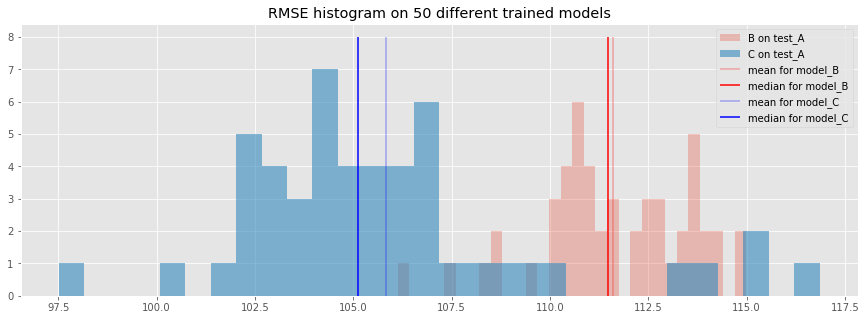

In [16]:
fig, ax = plt.subplots(figsize=[15,5], nrows=1, ncols=1)
#plt.hist(rmse_B[:,0], bins = 50, alpha=.5, label='B on test_B')
plt.hist(rmse_B[:,1], bins = 30, alpha=.3, label='B on test_A')
plt.vlines(rmse_B[:,1].mean(), 0, 8, color='r', alpha=0.3, label='mean for model_B')
plt.vlines(np.median(rmse_B[:,1]), 0, 8, color='r', label='median for model_B')

#plt.hist(rmse_C[:,0], bins = 50, alpha=.5, label='C on test_B')
plt.hist(rmse_C[:,1], bins = 30, alpha=.6, label='C on test_A')
plt.vlines(rmse_C[:,1].mean(), 0, 8, color='b', alpha=0.3, label='mean for model_C')
plt.vlines(np.median(rmse_C[:,1]), 0, 8, color='b', label='median for model_C')

#plt.hist(rmse_star, bins=50, alpha=.3, label='star on test A', color='g')
plt.title('RMSE histogram on {} different trained models'.format(len(rmse_B[:,1])))
plt.legend()

This last plot depends on the particular `model_B` and `model_C` that one is considering. Maybe we do it for 10 different models?

In [17]:
ntest_A = 100
rmse_B_on_A = np.zeros(ntest_A)
rmse_C_on_A = np.zeros(ntest_A)

for k in range(ntest_A):
    rnd_A = pd.DataFrame(pd.concat([xtest_A, ytest_A], axis=1), columns=data_A.columns).sample(500)
    rnd_y_A = rnd_A.Appliances
    rnd_X_A = ss_B.transform(rnd_A.drop(columns='Appliances'))
    rmse_B_on_A[k] = mean_squared_error(rnd_y_A, model_B.predict(rnd_X_A), squared=False)
    rmse_C_on_A[k] = mean_squared_error(rnd_y_A, model_C.predict(rnd_X_A), squared=False)

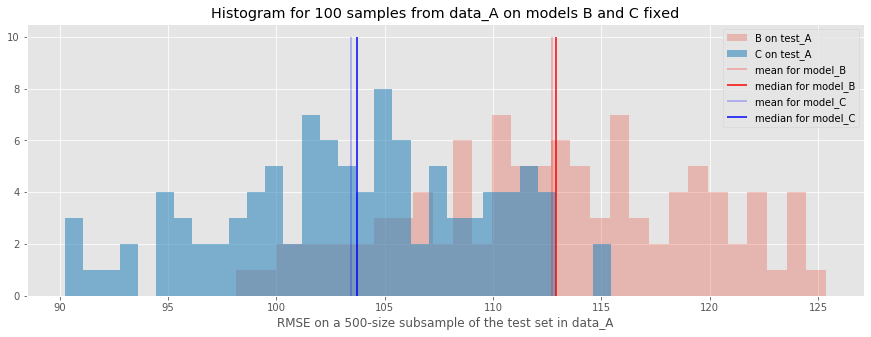

In [18]:
fig, ax = plt.subplots(figsize=[15,5], nrows=1, ncols=1)
plt.hist(rmse_B_on_A, bins = 30, alpha=.3, label='B on test_A')
plt.vlines(rmse_B_on_A.mean(), 0, 10, color='r', alpha=0.3, label='mean for model_B')
plt.vlines(np.median(rmse_B_on_A), 0, 10, color='r', label='median for model_B')

#plt.hist(rmse_C[:,0], bins = 50, alpha=.5, label='C on test_B')
plt.hist(rmse_C_on_A, bins = 30, alpha=.6, label='C on test_A')
plt.vlines(rmse_C_on_A.mean(), 0, 10, color='b', alpha=0.3, label='mean for model_C')
plt.vlines(np.median(rmse_C_on_A), 0, 10, color='b', label='median for model_C')

#plt.hist(rmse_star, bins=50, alpha=.3, label='star on test A', color='g')
plt.title('Histogram for {} samples from data_A on models B and C fixed'.format(ntest_A))
plt.xlabel('RMSE on a 500-size subsample of the test set in data_A')
plt.legend()